In [1]:
# reload import gwsnrdev with matplotlib reload
import gwsnrdev
import utils
import imp
import numpy as np
import matplotlib.pyplot as plt
import njit_functions
imp.reload(gwsnrdev)
imp.reload(utils)
imp.reload(njit_functions)


/var/folders/ws/0948zvwd7g795j2l3fryghjw0000gp/T/ipykernel_91562/1662763430.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<module 'njit_functions' from '/Users/phurailatpamhemantakumar/phd/mypackages/gwsnr/examples/njit_functions.py'>

In [2]:
gwsnr = gwsnrdev.GWSNR(snr_type='interpolation', create_new_interpolator=True, mtot_resolution=500, ratio_resolution=50, mtot_max=200, sampling_frequency=2048, minimum_frequency = 20.)

psds not given. Choosing bilby's default psds
npool:  4
snr_type:  interpolation
waveform_approximant:  IMRPhenomD
sampling_frequency:  2048
mtot_min:  2.0
mtot_max:  184.98599853446768
ratio_min:  0.1
ratio_max:  1.0
mtot_resolution:  500
ratio_resolution:  50
interpolator_dir:  ./interpolator_pickle
Interpolator will be generated for L1 detector at ./interpolator_pickle/L1/halfSNR_dict_20.pickle
Interpolator will be generated for H1 detector at ./interpolator_pickle/H1/halfSNR_dict_20.pickle
Interpolator will be generated for V1 detector at ./interpolator_pickle/V1/halfSNR_dict_20.pickle
Please be patient while the interpolator is generated
Generating interpolator for ['L1', 'H1', 'V1'] detectors


interpolation for each mass_ratios: 100%|███████████████████████████| 50/50 [01:07<00:00,  1.35s/it]


In [3]:
mass_1 = np.array([5, 10.,50.,100.])
ratio = np.array([1, 0.8,0.5,0.2])
gwsnr.compute_bilby_snr_(mass_1=mass_1, mass_2=mass_1*ratio)

{'L1': array([ 74.07114668, 115.9746314 , 310.35671092, 265.98690968]),
 'H1': array([ 47.11162031,  73.76357793, 197.39680269, 169.17618882]),
 'V1': array([22.2230551 , 34.40403504, 93.34736252, 78.61324627]),
 'optimal_snr_net': array([ 90.55331975, 141.68563154, 379.47399887, 324.88407391])}

In [4]:
# with interpolation
gwsnr.snr(mass_1=mass_1, mass_2=mass_1*ratio)

{'L1': array([ 74.07237228, 115.97500235, 310.36065119, 265.99021368]),
 'H1': array([ 47.11239983,  73.76381386, 197.39930883, 169.17829027]),
 'V1': array([22.22306148, 34.4041247 , 93.34870658, 78.61438369]),
 'optimal_snr_net': array([ 90.55472939, 141.68607977, 379.47885574, 324.88814843])}

In [5]:
nsamples = 1000
chirp_mass = np.linspace(5,80,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [6]:
# error might occur for mchirp>95., if f_min=20.
from datetime import datetime
gwsnr.multiprocessing_verbose = True
start_time = datetime.now()
bilby_ = gwsnr.compute_bilby_snr_(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
                            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

100%|████████████████████████████████████████████████████████████| 723/723 [00:01<00:00, 457.22it/s]

Duration: 0:00:01.634475


In [7]:
start_time = datetime.now()
mine_ = gwsnr.snr(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:00.018279


In [8]:
bilby_['L1'][:10]

array([20.3353021 , 86.12459306, 49.51214906, 87.1251482 , 46.51274369,
       88.58583084, 15.81746999, 52.26496408, 65.55831286, 34.53921849])

In [9]:
mine_['L1'][:10]

array([20.33452469, 86.12645888, 49.51078117, 87.12270272, 46.51284186,
       88.5863103 , 15.8171576 , 52.26487113, 65.5583132 , 34.53909677])

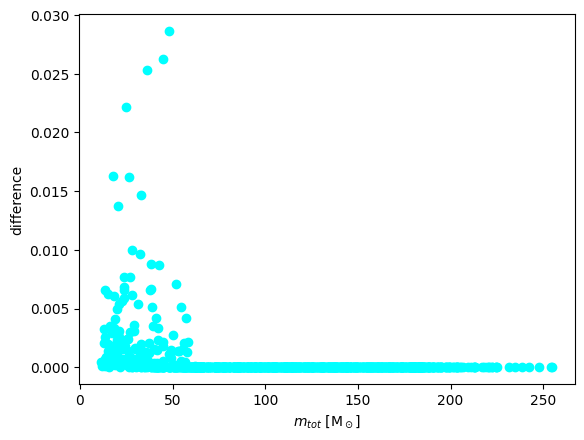

In [10]:
plt.plot(total_mass, abs(mine_['optimal_snr_net']-bilby_['optimal_snr_net']), 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"difference")
#plt.ylim(0,0.4)
plt.show()

In [9]:
import njit_functions
from scipy.optimize import fsolve
findchirp_chirptime = njit_functions.findchirp_chirptime
minimum_frequency = 20.
mass_ratio = 1.
Mo = 1.989 * 1e30

def func(x):
    # x = x*Mo
    safety = 1.2
    approx_duration = safety*findchirp_chirptime(x / (1 + mass_ratio), x / (1 + mass_ratio) * mass_ratio, minimum_frequency)

    return approx_duration

fsolve(func, 150)[0]

184.98599853446768

In [10]:
func(185)

-2.1329152720048706e-05

In [ ]:
optimal_snr = dict()
for j, det in enumerate(detectors):
    snr_buffer = np.zeros(size)
    snr_buffer[idx_tracker] = snr[j]
    optimal_snr[det] = snr_buffer
snr_buffer = np.zeros(size)
snr_buffer[idx_tracker] = snr_effective
optimal_snr["optimal_snr_net"] = snr_buffer

In [25]:
get_snr_half_scaled(mass_1, mass_2, luminosity_distance, theta_jn, psi, geocent_time, ra, dec, detector_tensor, np.array(snr_halfscaled), ratio_arr, mtot_arr)

(array([[134.45166202, 448.07960347, 704.01045424],
        [ 85.51556085, 284.99297087, 447.77318433],
        [ 40.82613804, 139.55146418, 215.66473154]]),
 array([164.48992101, 549.06368997, 861.76726598]))

In [23]:
gwsnr.snr_halfsacaled[0][4,0,0]

-0.002293025847495152

In [165]:
mass_1=np.array([10.,50.,100.])
mass_2=np.array([10.,50.,100.])
luminosity_distance=100.0
theta_jn=0.0
psi=0.0
phase=0.0
geocent_time=1246527224.169434
ra=0.0
dec=0.0


detector_tensor = np.array(gwsnr.detector_tensor_list)
detectors = np.array(gwsnr.detector_list)
snr_halfscaled = np.array(gwsnr.snr_halfsacaled)
size = len(mass_1)
mass_1, mass_2 = np.array([mass_1]).reshape(-1), np.array([mass_2]).reshape(-1)
luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec = (
    np.array([luminosity_distance]).reshape(-1) * np.ones(size),
    np.array([theta_jn]).reshape(-1) * np.ones(size),
    np.array([psi]).reshape(-1) * np.ones(size),
    np.array([phase]).reshape(-1) * np.ones(size),
    np.array([geocent_time]).reshape(-1) * np.ones(size),
    np.array([ra]).reshape(-1) * np.ones(size),
    np.array([dec]).reshape(-1) * np.ones(size),
)

mtot = mass_1 + mass_2
idx2 = (mtot >= gwsnr.mtot_min) & (mtot <= gwsnr.mtot_max)
idx_tracker = np.arange(size)
idx_tracker = idx_tracker[idx2]  # idx_tracker is the index of the required masses
size_ = len(idx_tracker)
if size_ == 0:
    print(
        "mass_1 and mass_2 must be within the range of mtot_min and mtot_max"
    )
    raise ValueError
# all other parameters should be of the same size
# this lessen the number of times the loop will run
mass_1, mass_2, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec = mass_1[idx2], mass_2[idx2], luminosity_distance[idx2], theta_jn[idx2], psi[idx2], phase[idx2], geocent_time[idx2], ra[idx2], dec[idx2]

ratio_arr = gwsnr.ratio_arr
mtot_arr = gwsnr.mtot_arr

In [61]:
import njit_functions
antenna_response = njit_functions.antenna_response
antenna_response_array = njit_functions.antenna_response_array

In [230]:
snr, snr_eff = get_snr_half_scaled(mass_1, mass_2, luminosity_distance, theta_jn, psi, geocent_time, ra, dec, detector_tensor, snr_halfscaled, ratio_arr, mtot_arr)

In [232]:
print(snr)
print(snr_eff)

[[126.96925444 429.87202737 703.99753522]
 [ 80.75651012 273.41236964 447.76496742]
 [ 37.43347242 129.9828042  215.65266571]]
[155.06150508 525.77543987 861.74942291]


In [226]:
from numba import njit
@njit
def get_snr_half_scaled(mass_1, mass_2, luminosity_distance, theta_jn, psi, geocent_time, ra, dec, detector_tensor, snr_halfscaled, ratio_arr, mtot_arr):
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    idx_ratio = np.searchsorted(ratio_arr, ratio)

    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))
    snr = np.zeros((len_,size))
    for j in range(len_):
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    snr = snr_half_ * A1 / d_eff
    snr_effective = np.sqrt(np.sum(snr ** 2, axis=0))

    return snr, snr_effective

@njit
def cubic_spline_interpolator2(xnew, ynew, coefficients, x, y):

    len_y = len(y)
    y_idx = np.searchsorted(y, ynew)
    # print(y_idx)
    if y_idx-1 <= 0:
        y_idx1 = 0
        y_idx2 = 1
        y_idx3 = 2
        y_idx4 = 4
        coeff_low, coeff_high = 0, 4
        # print("a")
    elif y_idx+1 >= len_y:
        y_idx1 = len_y - 4
        y_idx2 = len_y - 3
        y_idx3 = len_y - 2
        y_idx4 = len_y - 1
        coeff_low, coeff_high = 8, 12
        # print("b")
    else:
        y_idx1 = y_idx - 2
        y_idx2 = y_idx - 1
        y_idx3 = y_idx
        y_idx4 = y_idx + 1
        coeff_low, coeff_high = 4, 8
        # print("c")

    # print(y_idx1, y_idx2, y_idx3, y_idx4)
    # print(len(y))
    y1, y2, y3, y4 = y[y_idx1], y[y_idx2], y[y_idx3], y[y_idx4]
    z1 = cubic_spline_interpolator(xnew, coefficients[y_idx1], x)
    z2 = cubic_spline_interpolator(xnew, coefficients[y_idx2], x)
    z3 = cubic_spline_interpolator(xnew, coefficients[y_idx3], x)
    z4 = cubic_spline_interpolator(xnew, coefficients[y_idx4], x)

    coeff = coefficients_generator(y1, y2, y3, y4, z1, z2, z3, z4)
    matrixD = coeff[coeff_low:coeff_high]

    matrixB = np.array([ynew**3, ynew**2, ynew, 1])
    result = np.dot(matrixB, matrixD)

    return result

@njit
def cubic_spline_interpolator(xnew, coefficients, x):
    # Handling extrapolation
    i = np.searchsorted(x, xnew) - 1 if xnew > x[0] else 0

    # Calculate the relative position within the interval
    dx = xnew - x[i]

    # Calculate the interpolated value
    # Cubic polynomial: a + b*dx + c*dx^2 + d*dx^3
    a, b, c, d = coefficients[:, i]
    result = d + c*dx + b*dx**2 + a*dx**3
    return result

@njit
def coefficients_generator(y1, y2, y3, y4, z1, z2, z3, z4):
        
    matrixA = np.array([
        [y1**3, y1**2, y1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [y2**3, y2**2, y2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, y2**3, y2**2, y2, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, y3**3, y3**2, y3, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, y3**3, y3**2, y3, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, y4**3, y4**2, y4, 1],
        [3*y2**2, 2*y2, 1, 0, -3*y2**2, -2*y2, -1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 3*y3**2, 2*y3, 1, 0, -3*y3**2, -2*y3, -1, 0],
        [6*y2, 2, 0, 0, -6*y2, -2, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 6*y3, 2, 0, 0, -6*y3, -2, 0, 0],
        [6*y1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 6*y4, 2, 0, 0],
    ])
    matrixC = np.array([z1, z2, z2, z3, z3, z4, 0, 0, 0, 0, 0, 0])
    return np.dot(np.linalg.inv(matrixA), matrixC)

In [227]:
np.searchsorted(gwsnr.ratio_arr,1)

9

In [228]:
size = len(mass_1)
len_ = len(detector_tensor)
mtot = mass_1 + mass_2
ratio = mass_2 / mass_1
idx_ratio = np.searchsorted(ratio_arr, ratio)

Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
A1 = Mc ** (5.0 / 6.0)
ci_2 = np.cos(theta_jn) ** 2
ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2

size = len(mass_1)
snr_half_ = np.zeros((len_,size))
d_eff = np.zeros((len_,size))
snr = np.zeros((len_,size))

In [229]:
i = 2
j = 2
snr_half_coeff = snr_halfscaled[j]
cubic_spline_interpolator2(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
# %timeit test = cubic_spline_interpolator2(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)

1637.4340375715342

In [216]:
snr_half_coeff = snr_halfscaled[j][idx_ratio[i]]
cubic_spline_interpolator(mtot[i], snr_half_coeff, mtot_arr)
# %timeit cubic_spline_interpolator(mtot[i], snr_half_coeff, mtot_arr)

1637.4340375715476

In [147]:
from numba import njit
# @njit
def get_snr_half_scaled(mass_1, mass_2, luminosity_distance, theta_jn, psi, geocent_time, ra, dec, detector_tensor, snr_halfscaled, ratio_arr, mtot_arr):
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    idx_ratio = np.searchsorted(ratio_arr, ratio)

    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))
    snr = np.zeros((len_,size))
    for j in range(len_):
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j][idx_ratio[i]]
            snr_half_[j,i] = cubic_spline_interpolator(mtot[i], snr_half_coeff, mtot_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    snr = snr_half_ * A1 / d_eff
    snr_eff = np.sqrt(np.sum(snr ** 2, axis=0))

    return snr, snr_eff

# @njit
def cubic_spline_interpolator(xnew, coefficients, x):
    # Handling extrapolation
    i = np.searchsorted(x, xnew) - 1 if xnew > x[0] else 0
    # i = 0 if xnew <= x[0] else i
    # i = len(x) - 2 if xnew > x[-1] else i

    # Calculate the relative position within the interval
    dx = xnew - x[i]

    # Calculate the interpolated value
    # Cubic polynomial: a + b*dx + c*dx^2 + d*dx^3
    a, b, c, d = coefficients[:, i]
    result = d + c*dx + b*dx**2 + a*dx**3
    return result

In [ ]:
def cubic_spline_interpolator2(xnew, coefficients, x):
    # Handling extrapolation
    if 
    x_idx1 = x_idx-2
    x_idx2 = x_idx-1
    x_idx3 = x_idx
    x_idx4 = x_idx+1
    x1, x2, x3, x4 = x[x_idx1], x[x_idx2], x[x_idx3], x[x_idx4]
    z1, z2, z3, z4 = z[x_idx1], z[x_idx2], z[x_idx3], z[x_idx4]

    matrixA = np.array([
        [x1**3, x1**2, x1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [x2**3, x2**2, x2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, x2**3, x2**2, x2, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, x3**3, x3**2, x3, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, x3**3, x3**2, x3, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, x4**3, x4**2, x4, 1],
        [3*x2**2, 2*x2, 1, 0, -3*x2**2, -2*x2, -1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 3*x3**2, 2*x3, 1, 0, -3*x3**2, -2*x3, -1, 0],
        [6*x2, 2, 0, 0, -6*x2, -2, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 6*x3, 2, 0, 0, -6*x3, -2, 0, 0],
        [6*x1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 6*x4, 2, 0, 0],
    ])

    matrixC = np.array([z1, z2, z2, z3, z3, z4, 0, 0, 0, 0, 0, 0])
    coeff = np.dot(np.linalg.inv(matrixA), matrixC)
    matrixD = coeff[4:8]

In [6]:
gwsnr.compute_bilby_snr_(mass_1=np.array([10.,50.,100.]), mass_2=np.array([10.,50.,100.]))

100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.62it/s]


{'L1': array([126.70353165, 429.86494678, 703.99627287]),
 'H1': array([ 80.58750192, 273.40786617, 447.76416452]),
 'V1': array([ 37.52436425, 129.99019229, 215.65265711]),
 'opt_snr_net': array([154.77793225, 525.7691355 , 861.7479723 ])}

In [47]:
from gwsnr import GWSNR

snr = GWSNR(snr_type='interpolation', interpolator_dir="./test_pickle")

Given: IMR waveform, IMRPhenomD.
psds not given. Choosing bilby's default psds
given psds:  {'L1': 'aLIGO_O4_high_asd.txt', 'H1': 'aLIGO_O4_high_asd.txt', 'V1': 'AdV_asd.txt'}
Interpolator will be loaded for L1 detector from ./test_pickle/L1/halfSNR_dict_0.pickle
Interpolator will be loaded for H1 detector from ./test_pickle/H1/halfSNR_dict_0.pickle
Interpolator will be loaded for V1 detector from ./test_pickle/V1/halfSNR_dict_0.pickle


In [49]:
gwsnr.snr(mass_1=np.array([10.,50.,100.]), mass_2=np.array([10.,50.,100.]))

{'opt_snr_net': array([155.05383723, 525.7494292 , 861.7067818 ]),
 'L1': array([126.96526449, 429.85851885, 703.97541244]),
 'H1': array([ 80.74903698, 273.38706829, 447.72353162]),
 'V1': array([ 37.43136489, 129.97548607, 215.6405243 ])}

In [66]:
# njit_functions.py
from numba import njit
@njit
def einsum1(m,n):
    ans = np.zeros((3,3))
    ans[0,0] = m[0]*n[0]
    ans[0,1] = m[0]*n[1]
    ans[0,2] = m[0]*n[2]
    ans[1,0] = m[1]*n[0]
    ans[1,1] = m[1]*n[1]
    ans[1,2] = m[1]*n[2]
    ans[2,0] = m[2]*n[0]
    ans[2,1] = m[2]*n[1]
    ans[2,2] = m[2]*n[2]
    return ans
@njit
def einsum2(m,n):
    ans = m[0,0]*n[0,0] + m[0,1]*n[0,1] + m[0,2]*n[0,2] + m[1,0]*n[1,0] + m[1,1]*n[1,1] + m[1,2]*n[1,2] + m[2,0]*n[2,0] + m[2,1]*n[2,1] + m[2,2]*n[2,2]
    return ans

@njit
def gps_to_gmst(gps_time):
    slope = 7.292115855382993e-05
    time0 = 1126259642.413
    time = gps_time - time0
    return slope*time+36137.068361399164

@njit
def ra_dec_to_theta_phi(ra, dec, gmst):
    phi = ra - gmst
    theta = np.pi / 2.0 - dec
    return theta, phi

@njit
def get_polarization_tensor(ra, dec, time, psi, mode='plus'):
    gmst = np.fmod(gps_to_gmst(time), 2 * np.pi)
    theta, phi = ra_dec_to_theta_phi(ra, dec, gmst)
    u = np.array([np.cos(phi) * np.cos(theta), np.cos(theta) * np.sin(phi), -np.sin(theta)])
    v = np.array([-np.sin(phi), np.cos(phi), 0])
    m = -u * np.sin(psi) - v * np.cos(psi)
    n = -u * np.cos(psi) + v * np.sin(psi)

    if mode == 'plus':
        return einsum1(m, m) - einsum1(n, n)
    elif mode == 'cross':
        return einsum1(m, n) + einsum1(n, m)

@njit
def antenna_response(ra, dec, time, psi, detector_tensor, mode='plus'):

    polarization_tensor = get_polarization_tensor(ra, dec, time, psi, mode=mode)
    return einsum2(detector_tensor, polarization_tensor)

@njit
def antenna_response_array(ra, dec, time, psi, detector_tensor):

    len1 = len(detector_tensor)
    len2 = len(ra) 
    Fp = np.zeros_like(ra)
    Fc = np.zeros_like(ra)
    ans = np.zeros((2,2,len2))

    for i in range(len1):
        for j in range(len2):
            # print("ra", ra[j])
            # print("dec", dec[j])
            # print("time", time[j])
            # print("psi", psi[j])
            # print("detector_tensor", detector_tensor[i])
            Fp[j] = antenna_response(ra[j], dec[j], time[j], psi[j], detector_tensor[i], mode="plus")
            Fc[j] = antenna_response(ra[j], dec[j], time[j], psi[j], detector_tensor[i], mode="cross")
        ans[i,0,:] = Fp
        ans[i,1,:] = Fc

    return ans

# detector_tensor 

In [67]:
# define values
size = 50000
time = 1126259642.413*np.ones(size)
ra = 1.375*np.ones(size)
dec = -1.2108*np.ones(size)
psi = 0.1*np.ones(size)
mode = "plus"
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
len_ = len(ifos)
detector_tensor = np.zeros((len_,3,3))
for i in range(len_):
    detector_tensor[i]=ifos[i].detector_tensor
detector_tensor = np.array(detector_tensor)
#detector_tensor = ifos[0].detector_tensor

In [72]:
bilby.gw.detector.InterferometerList(['H1'])

[Interferometer(name='H1', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), minimum_frequency=20.0, maximum_frequency=2048.0, length=4.0, latitude=46.45514666666667, longitude=-119.4076571388889, elevation=142.554, xarm_azimuth=125.9994, yarm_azimuth=215.9994, xarm_tilt=-0.0006195, yarm_tilt=1.25e-05)]

In [68]:
%timeit test = antenna_response_array(ra, dec, time, psi, detector_tensor)

78.7 ms ± 5.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [69]:
np.shape(test)

(2, 2, 25000)

In [70]:
def antenna_response_array(ra, dec, time, psi, ifos):

    len1 = len(ifos)
    len2 = len(ra) 
    Fp = np.zeros_like(ra)
    Fc = np.zeros_like(ra)
    ans = np.zeros((2,2,len2))

    for i in range(len1):
        for j in range(len2):
            # print("ra", ra[j])
            # print("dec", dec[j])
            # print("time", time[j])
            # print("psi", psi[j])
            # print("detector_tensor", detector_tensor[i])
            Fp[j] = ifos[i].antenna_response(ra[j], dec[j], time[j], psi[j], "plus")
            Fc[j] = ifos[i].antenna_response(ra[j], dec[j], time[j], psi[j], "cross")
        ans[i,0,:] = Fp
        ans[i,1,:] = Fc

    return ans

In [71]:
%timeit test = antenna_response_array(ra, dec, time, psi, ifos)

284 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [2]:
from gwsnr import GWSNR
snr = GWSNR()

Given: IMR waveform, IMRPhenomD.
psds not given. Choosing bilby's default psds
given psds:  {'L1': 'aLIGO_O4_high_asd.txt', 'H1': 'aLIGO_O4_high_asd.txt', 'V1': 'AdV_asd.txt'}
Interpolator will be generated for L1 detector at ./interpolator_pickle/L1/halfSNR_dict_0.pickle
Interpolator will be generated for H1 detector at ./interpolator_pickle/H1/halfSNR_dict_0.pickle
Interpolator will be generated for V1 detector at ./interpolator_pickle/V1/halfSNR_dict_0.pickle
Generating interpolator for ['L1', 'H1', 'V1'] detectors


interpolation for each mass_ratios: 100%|███████████████████████████| 50/50 [01:16<00:00,  1.54s/it]

interpolator generated


In [3]:
gwsnr.snr(mass_1=10.0, mass_2=10.0, luminosity_distance=100.0, theta_jn=0.0, psi=0.0, phase=0.0, geocent_time=1246527224.169434, ra=0.0, dec=0.0)

{'opt_snr_net': array([155.05383723]),
 'L1': array([126.96526449]),
 'H1': array([80.74903698]),
 'V1': array([37.43136489])}

In [5]:
psd_file = dict(L1=False, H1=False)
list_of_detectors = ['L1', 'H1']
if list(psd_file.keys())==list_of_detectors:
    pass
else:
    print("psd_file must be a dictionary with keys: {}".format(list_of_detectors))

In [3]:
list(psd_file.keys())

['L1', 'H1']

In [15]:
from gwpy.timeseries import TimeSeries

psd_with_time = 1126259462.4
duration = 4.0
roll_off = 0.2
psd_duration = duration * 32.0  # uint (seconds)
psd_start_time = psd_with_time - psd_duration
detectors = ['L1', 'H1']
psds_arrays = dict()
for ifo in detectors:
    psd_data = TimeSeries.fetch_open_data(
        ifo,
        psd_start_time,
        psd_start_time + psd_duration,
        sample_rate=4096,
        cache=True,
    )

    psd_alpha = 2 * roll_off / duration
    det_psd = psd_data.psd(
        fftlength=duration,
        overlap=0.5,
        window=("tukey", psd_alpha),
        method="median",
    )



NameError: name 'bilby' is not defined

In [16]:
import bilby
psds_arrays[ifo] = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=det_psd.frequencies.value, psd_array=det_psd.value
)

In [17]:
psds_arrays

{'L1': PowerSpectralDensity(frequency_array=[0.00000e+00 2.50000e-01 5.00000e-01 ... 2.04750e+03 2.04775e+03
  2.04800e+03], psd_array=[1.07364242e-41 4.10526641e-43 6.59660419e-43 ... 1.92749162e-50
  2.63739232e-50 1.00854544e-50], asd_array=[3.27664831e-21 6.40723529e-22 8.12194816e-22 ... 1.38834132e-25
  1.62400503e-25 1.00426363e-25])}

In [20]:
test = bilby.gw.detector.PowerSpectralDensity(asd_file="aLIGO_O4_high_asd.txt")

In [63]:
waveform_arguments = dict(
    waveform_approximant="IMRPhenomD",
    reference_frequency=20.0,
    minimum_frequency=20.,
)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=16,
    sampling_frequency=2048,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
)
waveform_generator.duration = 4
#len(test.get_power_spectral_density_array(waveform_generator.frequency_array))
len(waveform_generator.frequency_array)

04:11 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


4097

In [64]:
psds_arrays['L1'].get_power_spectral_density_array(waveform_generator.frequency_array)

array([1.07364242e-41, 4.10526641e-43, 6.59660419e-43, ...,
       4.23470699e-43, 3.90148669e-43, 5.84714064e-43])

In [65]:
import numpy as np
waveform_generator.duration = 16
parameters=dict(
    mass_1=10.0, mass_2=10.0, luminosity_distance=100.0, theta_jn=0.0, psi=0.0, phase=0.0, geocent_time=1246527224.169434, ra=0.0, dec=0.0, a_1=0.0, a_2=0.0, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0
)
len(waveform_generator.frequency_domain_strain(parameters=parameters)['plus'])

16385

In [57]:
len(waveform_generator.frequency_array)

16385

In [60]:
waveform_generator.frequency_domain_source_model

<function bilby.gw.source.lal_binary_black_hole(frequency_array, mass_1, mass_2, luminosity_distance, a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phase, **kwargs)>

In [3]:
import numpy as np
import bilby

size = 100
mass_1 = 30.*np.ones(size)
mass_2 = 30.*np.ones(size)
luminosity_distance = 100.*np.ones(size)
theta_jn = 0.*np.ones(size)
psi = 0.*np.ones(size)
phase = 0.*np.ones(size)
geocent_time = 1246527224.169434*np.ones(size)
ra = 0.*np.ones(size)
dec = 0.*np.ones(size)
a_1 = 0.*np.ones(size)
a_2 = 0.*np.ones(size)
tilt_1 = 0.*np.ones(size)
tilt_2 = 0.*np.ones(size)
phi_12 = 0.*np.ones(size)
phi_jl = 0.*np.ones(size)
size1 = len(mass_1)
iterations = np.arange(size1)  # to keep track of index
detectors = ['L1', 'H1']
dectectorList = np.array(detectors) * np.ones(
    (size1, len(detectors)), dtype=object
)
approximant = "IMRPhenomD"
f_min = 20.0
sampling_frequency = 2048.0
duration = 4.0*np.ones(size)

psds = dict()
psds["L1"] = "aLIGO_O4_high_asd.txt"
psds["H1"] = "aLIGO_O4_high_asd.txt"
psds_arrays = dict()
for det in detectors:
    psds_arrays[det] = bilby.gw.detector.PowerSpectralDensity(asd_file=psds[det])
psds_arrays_list = np.array([np.full(size1, psds_arrays, dtype=object)]).T

input_arguments = np.array(
    [
        mass_1,
        mass_2,
        luminosity_distance,
        theta_jn,
        psi,
        phase,
        ra,
        dec,
        geocent_time,
        a_1,
        a_2,
        tilt_1,
        tilt_2,
        phi_12,
        phi_jl,
        np.full(size1, approximant),
        np.full(size1, f_min),
        duration,
        np.full(size1, sampling_frequency),
        iterations,
    ],
    dtype=object,
    ).T

input_arguments = np.concatenate(
    (input_arguments, psds_arrays_list, dectectorList), axis=1
)

In [4]:
import multiprocessing_routine
import njit_functions
# reload
import importlib
importlib.reload(multiprocessing_routine)
importlib.reload(njit_functions)

<module 'njit_functions' from '/Users/phurailatpamhemantakumar/phd/mypackages/gwsnr/examples/njit_functions.py'>

In [3]:
hp_inner_hp_i, hc_inner_hc_i, iter_i = multiprocessing_routine.noise_weighted_inner_prod(input_arguments[0])

In [4]:
len(hp_inner_hp_i)

2

In [15]:
# now with multiprocessing
from multiprocessing import Pool
from tqdm import tqdm

verbose = True
# complex
hp_inner_hp = np.zeros((size1,2), dtype=np.complex128)
hc_inner_hc = np.zeros((size1,2), dtype=np.complex128)
iter = np.arange(size1)
with Pool(processes=4) as pool:
    for result in tqdm(
        pool.imap_unordered(
            multiprocessing_routine.noise_weighted_inner_prod, input_arguments
        ),
        total=len(input_arguments),
        ncols=100,
        disable=not verbose,
    ):
        hp_inner_hp_i, hc_inner_hc_i, iter_i = result

        hp_inner_hp[iter_i] = hp_inner_hp_i
        hc_inner_hc[iter_i] = hc_inner_hc_i

100%|█████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 74.39it/s]


In [16]:
ifos = bilby.gw.detector.InterferometerList(detectors)
detector_tensor = []
for j in range(len(detectors)):
    detector_tensor.append(ifos[j].detector_tensor)
detector_tensor = np.array(detector_tensor)

In [17]:
detector_tensor

array([[[ 0.41128086,  0.14021027,  0.24729459],
        [ 0.14021027, -0.10900569, -0.18161563],
        [ 0.24729459, -0.18161563, -0.30227517]],

       [[-0.3926141 , -0.07761341, -0.24738904],
        [-0.07761341,  0.31952407,  0.22799783],
        [-0.24738904,  0.22799783,  0.07309003]]])

In [18]:
Fp, Fc = njit_functions.antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

In [19]:
np.shape(Fp)

(100, 2)

In [20]:
detectors = ['L1', 'H1']
num_det = np.arange(len(detectors), dtype=int)
psds_list = [1,2]
psd_dict = {detectors[i]: psds_list[i] for i in num_det}

In [11]:
psd_dict

{'L1': 1, 'H1': 2}

In [10]:
np.shape(hp_inner_hp)

(100, 2)

In [20]:
snrs_sq[0]

array([85612.52743128, 34633.41085401])

In [21]:
np.sqrt(85612.52743128+34633.41085401)

346.7649611556652

In [21]:
SNRs_dict = dict()
snrs_sq = abs((Fp**2) * hp_inner_hp + (Fc**2) * hc_inner_hc)
SNRs_dict["opt_snr_net"] = np.sqrt(np.sum(snrs_sq, axis=1))
j = 0
for det in detectors:
    SNRs_dict[det] = np.sqrt(snrs_sq[:,j])
    j += 1

In [11]:
from scipy.optimize import fsolve
import numpy as np
import njit_functions

mass_ratio = 0.1
f_min = 20.0
func = lambda x: njit_functions.findchirp_chirptime(
    x / (1 + mass_ratio), x / (1 + mass_ratio) * mass_ratio, f_min
)
fsolve(func, 150)[
    0
]

145.5926919415139

In [8]:
def last_stable_orbit_frequency(m1, m2):
    # Constants
    c = 299792458  # Speed of light in meters per second
    G = 6.67430e-11  # Gravitational constant in m^3 kg^(-1) s^(-2)
    Mo = 1.988409870698051e30  # Solar mass in kg
    m1 = m1 * Mo  # Convert m1 to kg
    m2 = m2 * Mo  # Convert m2 to kg

    # Calculate LSO frequency
    f_gw = c**3 / (6**(3/2) * np.pi * G * (m1 + m2))

    return f_gw

In [9]:
last_stable_orbit_frequency(184,184)

11.94884445825218

In [ ]:
 / (1 + mass_ratio)

In [ ]:
npool=int(4),
        mtot_min=2.0,
        mtot_max=439.6,
        ratio_min=0.1,
        ratio_max=1.0,
        mtot_resolution=100,
        ratio_resolution=100,
        sampling_frequency=2048.0,
        waveform_approximant="IMRPhenomD",
        minimum_frequency=20.0,
        snr_type="interpolation",
        psds=None,
        isit_psd_file=False,
        ifos=None,
        interpolator_dir="./interpolator_pickle",
        create_new_interpolator=False,
        gwsnr_verbose=True,
        multiprocessing_verbose=True,

# setting instance attributes
        self.npool = npool
        self.mtot_min = mtot_min
        self.mtot_max = mtot_max
        self.ratio_min = ratio_min
        self.ratio_max = ratio_max
        self.mtot_resolution = mtot_resolution
        self.ratio_resolution = ratio_resolution
        # buffer of 0.01 is added to the ratio
        self.ratio_arr = np.geomspace(ratio_min-0.01, ratio_max+0.01, ratio_resolution)
        # buffer of 0.1 is added to the mtot
        self.mtot_arr = np.sort(
            mtot_min + mtot_max - np.geomspace(mtot_min-0.1, mtot_max+0.1, mtot_resolution)
        )
        self.sampling_frequency = sampling_frequency
        self.waveform_approximant = waveform_approximant
        self.f_min = minimum_frequency
        self.snr_type = snr_type
        self.interpolator_dir = interpolator_dir

In [13]:
import bilby
import lalsimulation as lal

AttributeError: module 'lalsimulation' has no attribute 'solar_mass_in_kg'

In [19]:
gw_param_dict = dict()
a_1 = gw_param_dict.get("a_1", 0)

In [20]:
a_1

0